# Подготовка среды

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/test')

In [3]:
print(os.getcwd())

/content/drive/My Drive/test


In [4]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 33.4 MB/s eta 0:00:00


# Данные

https://public.roboflow.com/classification/rock-paper-scissors - для распознавания жестов<br>
https://lmb.informatik.uni-freiburg.de/resources/datasets/FreihandDataset.en.html - для ключевых точек (дополнительно)

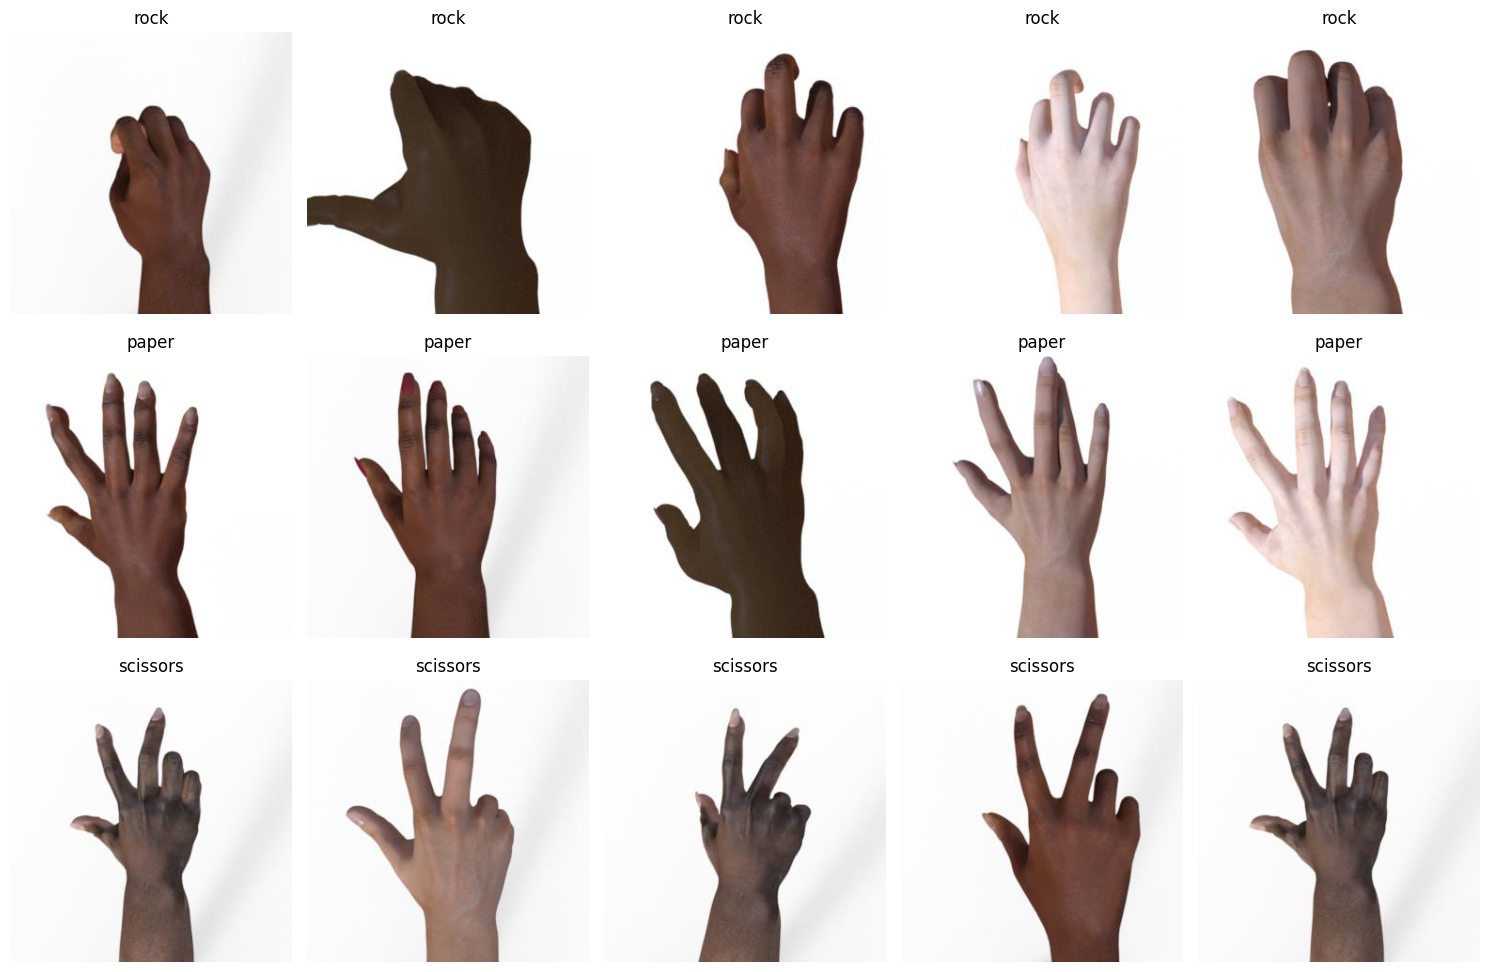

In [52]:
data_dir = '/content/drive/My Drive/test/dataset/train'
gestures = ['rock', 'paper', 'scissors']

gesture_images = {gesture: [] for gesture in gestures}

for gesture in gestures:
    gesture_path = os.path.join(data_dir, gesture)
    images = os.listdir(gesture_path)
    selected_images = images[:5]  # Берем первые 5 изображений
    for img_name in selected_images:
        img_path = os.path.join(gesture_path, img_name)
        gesture_images[gesture].append(img_path)

plt.figure(figsize=(15, 10))

for i, gesture in enumerate(gestures):
    for j in range(5):
        if j < len(gesture_images[gesture]):
            img_path = gesture_images[gesture][j]
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(3, 5, i * 5 + j + 1)
            plt.imshow(img_rgb)
            plt.title(gesture)
            plt.axis('off')

plt.tight_layout()
plt.show()

In [53]:
data_dir = '/content/drive/My Drive/test/dataset'
splits = ['train', 'valid', 'test']
gestures = ['rock', 'paper', 'scissors']

image_counts = {split: {gesture: 0 for gesture in gestures} for split in splits}

for split in splits:
    for gesture in gestures:
        gesture_path = os.path.join(data_dir, split, gesture)
        if os.path.exists(gesture_path):
            images = os.listdir(gesture_path)
            image_counts[split][gesture] = len(images)

for split in splits:
    print(f"Количество изображений в {split}:")
    for gesture in gestures:
        print(f"{gesture.capitalize()}: {image_counts[split][gesture]}")
    print()

total_images = 0

for split in splits:
    for gesture in gestures:
        total_images += image_counts[split][gesture]

print(f"Общее количество изображений: {total_images}")

height, width, channels = img.shape
print(f"Размер изображений: {width}x{height} пикселей")

Количество изображений в train:
Rock: 840
Paper: 840
Scissors: 840

Количество изображений в valid:
Rock: 124
Paper: 124
Scissors: 124

Количество изображений в test:
Rock: 11
Paper: 11
Scissors: 11

Общее количество изображений: 2925
Размер изображений: 300x300 пикселей


# Обучение модели

In [42]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

### Подготовка данных (сбор ключевых точек и меток)

Метка: paper
Ключевые точки: [(0.5764349102973938, 0.735598087310791), (0.4411352872848511, 0.6970967054367065), (0.3428535461425781, 0.6067233681678772), (0.25165706872940063, 0.5256050229072571), (0.16772636771202087, 0.49264881014823914), (0.4325077533721924, 0.5172330141067505), (0.3607608675956726, 0.38376396894454956), (0.32893091440200806, 0.31216755509376526), (0.31285756826400757, 0.2586368918418884), (0.5171069502830505, 0.48336997628211975), (0.45479142665863037, 0.31836020946502686), (0.4202482998371124, 0.22413811087608337), (0.40081101655960083, 0.15619808435440063), (0.5938273668289185, 0.4680016338825226), (0.5502341389656067, 0.2984919548034668), (0.5206739902496338, 0.20398283004760742), (0.49806177616119385, 0.13093483448028564), (0.6551772952079773, 0.4670741558074951), (0.6540765166282654, 0.333368718624115), (0.6519448757171631, 0.24967992305755615), (0.6485546827316284, 0.17568805813789368)]


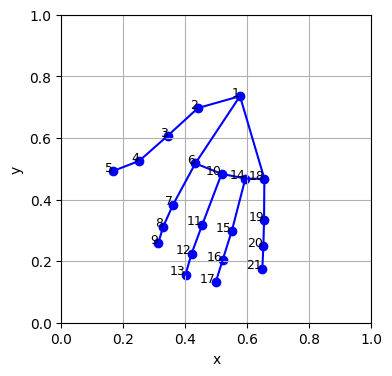

In [73]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True)

image_path = '/content/drive/My Drive/test/dataset/train/paper/paper04-096_png.rf.5ae0b19d6baecbc31f0a93c94037ebff.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = hands.process(image_rgb)

example_data = None

if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        keypoints = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
        gesture = 'paper'
        example_data = (keypoints, gesture)

keypoints, gesture = example_data

print(f"Метка: {gesture}")
print(f"Ключевые точки: {keypoints}")

x_coords = [point[0] for point in keypoints]
y_coords = [point[1] for point in keypoints]

plt.figure(figsize=(4, 4))

plt.scatter(x_coords, y_coords, marker='o', color='b')

for i in range(len(keypoints)):
    plt.text(x_coords[i], y_coords[i], str(i + 1), fontsize=9, ha='right', color='black')

plt.plot(x_coords[0:5], y_coords[0:5], color='b')
plt.plot([x_coords[5], x_coords[9], x_coords[13], x_coords[17]], [y_coords[5], y_coords[9], y_coords[13], y_coords[17]], color='b')
plt.plot([x_coords[0], x_coords[5]], [y_coords[0], y_coords[5]], color='b')
plt.plot([x_coords[0], x_coords[17]], [y_coords[0], y_coords[17]], color='b')
plt.plot(x_coords[5:9], y_coords[5:9], color='b')
plt.plot(x_coords[9:13], y_coords[9:13], color='b')
plt.plot(x_coords[13:17], y_coords[13:17], color='b')
plt.plot(x_coords[17:21], y_coords[17:21], color='b')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.axvline(0, color='black', linewidth=0.5, ls='--')

plt.show()

In [13]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,
                        max_num_hands=1,
                        min_detection_confidence=0.7)

data_dir = '/content/drive/My Drive/test/dataset'
gesture_data = []

# Сбор данных
for split in ['train', 'valid', 'test']:
    for gesture in ['rock', 'paper', 'scissors']:
        gesture_path = os.path.join(data_dir, split, gesture)
        for img_name in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = hands.process(image_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    keypoints = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
                    gesture_data.append((keypoints, gesture)) # Данные: ключевые точки + метка

# Сохраняем данные в файл
with open('/content/drive/My Drive/test/gesture_data.pkl', 'wb') as f:
    pickle.dump(gesture_data, f)

print(f"Собрано {len(gesture_data)} записей")

Собрано 2806 записей


In [74]:
for i in range(3):
    keypoints, gesture = gesture_data[i]
    print(f"Запись {i + 1}:")
    print(f"Ключевые точки: {keypoints}")
    print(f"Жест: {gesture}")
    print()

Запись 1:
Ключевые точки: [(0.5944343209266663, 0.7409512996673584), (0.44107696413993835, 0.6641701459884644), (0.39614981412887573, 0.5596340298652649), (0.4236905872821808, 0.4748031198978424), (0.45329171419143677, 0.40604546666145325), (0.48173531889915466, 0.4594137370586395), (0.42545241117477417, 0.3416914939880371), (0.38401365280151367, 0.3492603898048401), (0.3803354501724243, 0.3934047222137451), (0.5646060109138489, 0.462706059217453), (0.5137721300125122, 0.30335167050361633), (0.4682588577270508, 0.3212431073188782), (0.4593093991279602, 0.3651735782623291), (0.6299126148223877, 0.46774035692214966), (0.5837359428405762, 0.3404058814048767), (0.5351186990737915, 0.36256349086761475), (0.5149218440055847, 0.39773857593536377), (0.6715488433837891, 0.4772215783596039), (0.6277103424072266, 0.4047507047653198), (0.5765954256057739, 0.4150694012641907), (0.5546712875366211, 0.44224968552589417)]
Жест: rock

Запись 2:
Ключевые точки: [(0.7049262523651123, 0.787094235420227), 

### Подготовка данных (обучающая и тестовая выборки)

In [75]:
# Загрузка данных из файла
with open('/content/drive/My Drive/test/gesture_data.pkl', 'rb') as f:
    gesture_data = pickle.load(f)

print(f"Загружено {len(gesture_data)} записей")

X = []
y = []

for keypoints, gesture in gesture_data:
    X.append(keypoints)
    y.append(['rock', 'paper', 'scissors'].index(gesture))  # Метки в индексы

X = np.array(X)
y = np.array(y)

X = X / np.max(X)  # Нормализуем координаты в диапазон [0, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Загружено 2806 записей


In [76]:
for i in range(3):
    print(f"Запись {i + 1}:")
    print(f"X_train: {X_train[i]}")
    print(f"y_train: {y_train[i]}")
    print()

Запись 1:
X_train: [[0.53173906 0.75854411]
 [0.38399338 0.71807481]
 [0.28091598 0.649588  ]
 [0.17603644 0.59378279]
 [0.08023685 0.5618605 ]
 [0.37014639 0.52033533]
 [0.27398711 0.35700045]
 [0.22333473 0.25664032]
 [0.18793361 0.17956712]
 [0.46191947 0.49406808]
 [0.40287099 0.30955155]
 [0.36608665 0.20237876]
 [0.34205727 0.1282798 ]
 [0.54699301 0.49068944]
 [0.50061898 0.31051096]
 [0.46560352 0.20396613]
 [0.4384876  0.12652591]
 [0.61736655 0.49624119]
 [0.60480741 0.3568709 ]
 [0.59529161 0.2719792 ]
 [0.58491503 0.19682497]]
y_train: 1

Запись 2:
X_train: [[0.53813403 0.72481795]
 [0.41483842 0.66126547]
 [0.34459495 0.56937042]
 [0.27250416 0.48772203]
 [0.20578625 0.437068  ]
 [0.47193087 0.46732357]
 [0.45632891 0.29698274]
 [0.44693245 0.19692834]
 [0.44872509 0.12087884]
 [0.55687486 0.46105665]
 [0.58152726 0.30015657]
 [0.59507471 0.21750867]
 [0.61158782 0.16365471]
 [0.62394988 0.47871589]
 [0.60315499 0.37955477]
 [0.56432438 0.39975494]
 [0.54524183 0.43766025]

### Создание модели

Это простая полносвязная нейронная сеть (DNN). Линейная: выход предыдущего слоя становится входом для следующего слоя.

Input слой определяет форму входных данных.<br>
Flatten слой преобразует многомерный массив входных данных в одномерный вектор (это необходимо для передачи данных в полносвязные слои).<br>
Dense слои с 64, 32 нейронами и функцией активации ReLU (предназначены для извлечения признаков: базовые + более абстрактные).<br>
Dense слой с 3 нейронами (количество классов) и функцией активации softmax (выходы слоя - вероятности классов).




In [81]:
model = models.Sequential()
model.add(layers.Input(shape=(21, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [82]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# Оценка модели на тестовой выборке
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5719 - loss: 1.0436
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9212 - loss: 0.6917
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9588 - loss: 0.3573
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9731 - loss: 0.1865
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9872 - loss: 0.1053
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9952 - loss: 0.0658
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9983 - loss: 0.0490
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0377
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9991 - loss: 0.0269
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0218
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9991 - loss: 0.0186  
Test accuracy: 0.9983


In [83]:
model.save('/content/drive/My Drive/test/gesture_classification_model.h5')

### Результаты модели

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import mediapipe as mp
import os

#### На тренировочных данных

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


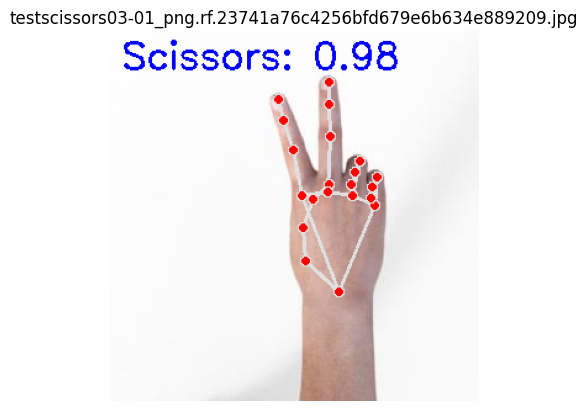

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


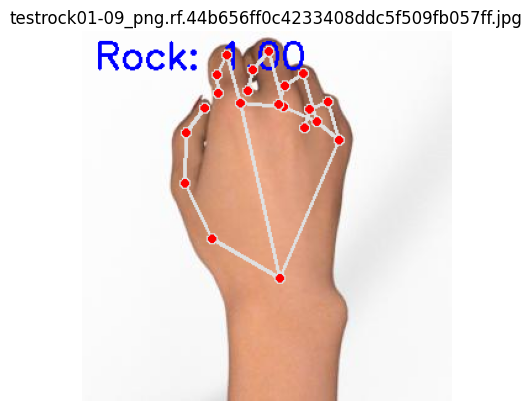

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


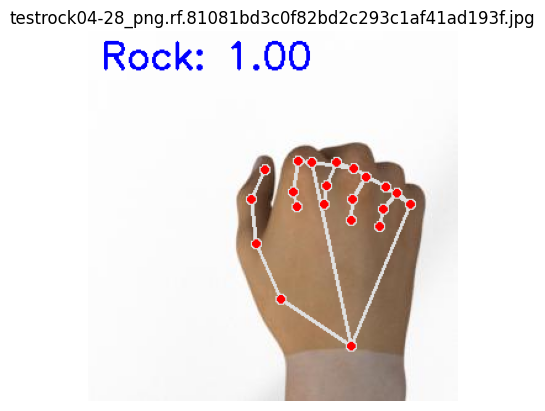

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


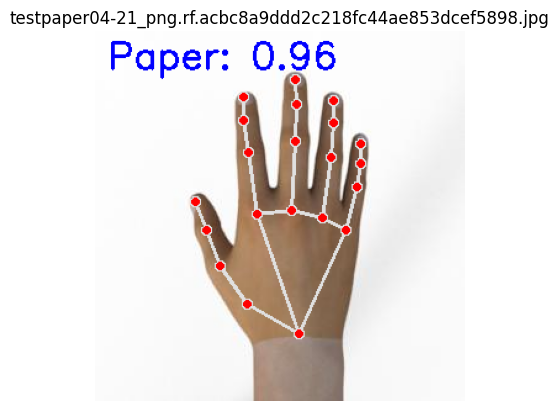

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


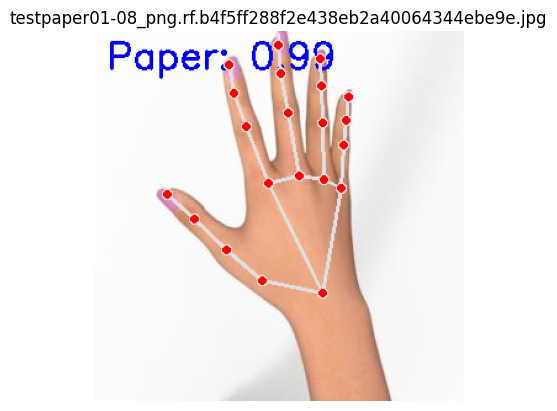

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


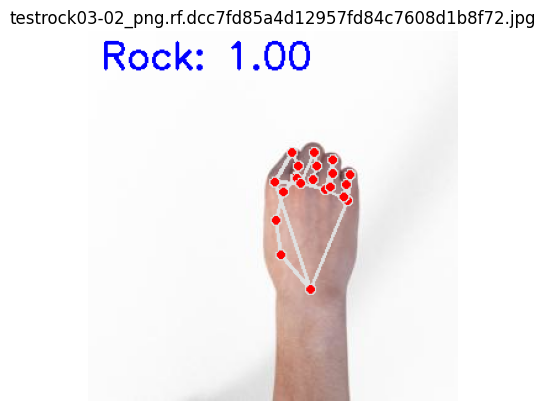

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


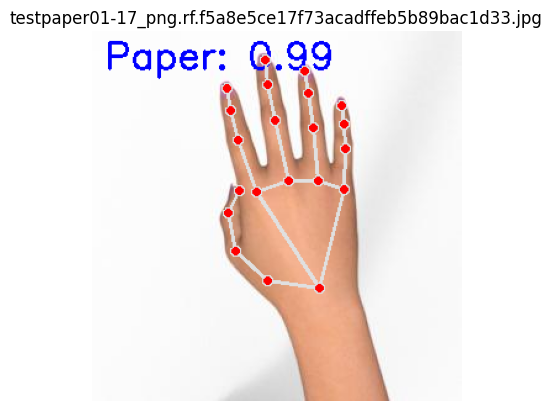

In [86]:
model = load_model('/content/drive/My Drive/test/gesture_classification_model.h5')

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.7)

images_folder = 'screens'

image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

for image_file in image_files:
    image_path = os.path.join(images_folder, image_file)
    img_input = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)

    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            class_names = {0: 'Rock', 1: 'Paper', 2: 'Scissors'}

            keypoints = [(lm.x, lm.y) for lm in hand_landmarks.landmark]

            keypoints_normalized = np.array(keypoints) / 1.0

            img_input_model = np.expand_dims(keypoints_normalized, axis=0)

            predictions = model.predict(img_input_model)
            predicted_class = np.argmax(predictions[0])
            predicted_probability = predictions[0][predicted_class]

            text = f'{class_names[predicted_class]}: {predicted_probability:.2f}'
            cv2.putText(img_input, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            mp.solutions.drawing_utils.draw_landmarks(img_input, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    plt.imshow(cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image_file)
    plt.show()

#### На кадрах видео

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


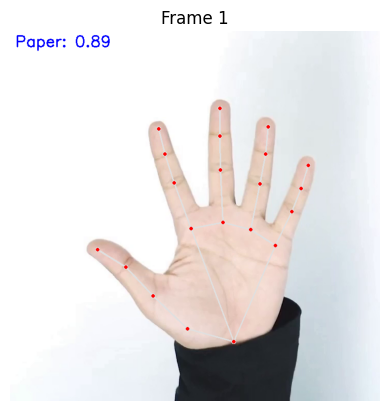

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


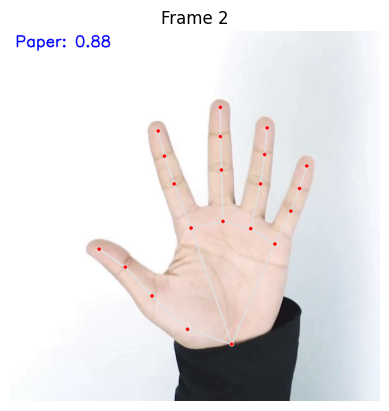

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


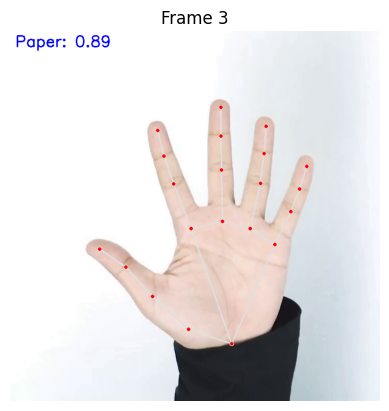

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


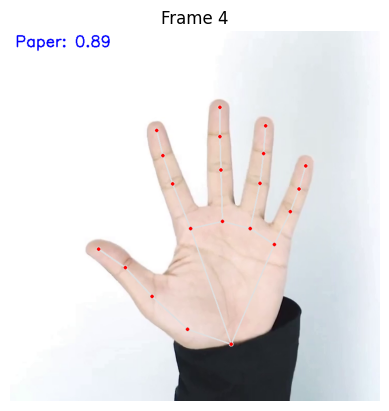

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


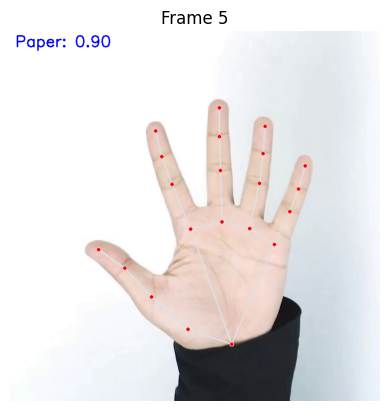

In [88]:
model = load_model('/content/drive/My Drive/test/gesture_classification_model.h5')

class_names = {0: 'Rock', 1: 'Paper', 2: 'Scissors'}

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)

video_path = 'example.mp4'
cap = cv2.VideoCapture(video_path)

num_frames_to_process = 5
frame_count = 0

while cap.isOpened() and frame_count < num_frames_to_process:
    ret, frame = cap.read()
    if not ret:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            keypoints = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
            keypoints_normalized = np.array(keypoints) / 1.0
            img_input_model = np.expand_dims(keypoints_normalized, axis=0)  # Добавляем размерность для батча

            predictions = model.predict(img_input_model)
            predicted_class = np.argmax(predictions[0])
            predicted_probability = predictions[0][predicted_class]

            text = f'{class_names[predicted_class]}: {predicted_probability:.2f}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            mp.solutions.drawing_utils.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    else:
        print("Рука не обнаружена.")

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Frame {frame_count + 1}')
    plt.show()

    frame_count += 1

cap.release()
cv2.destroyAllWindows()

# Обработка видео

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from keras.models import load_model

### Pipeline

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


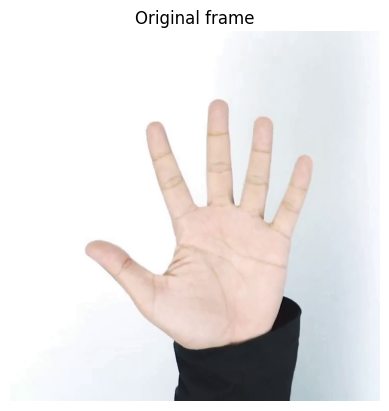

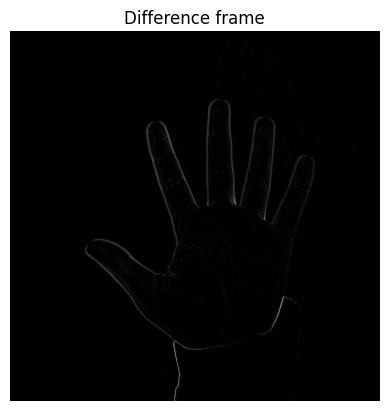

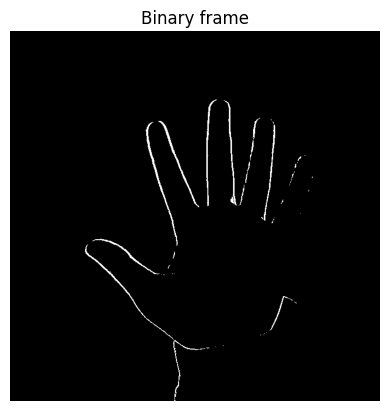

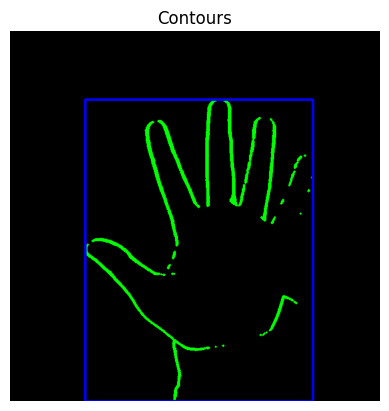

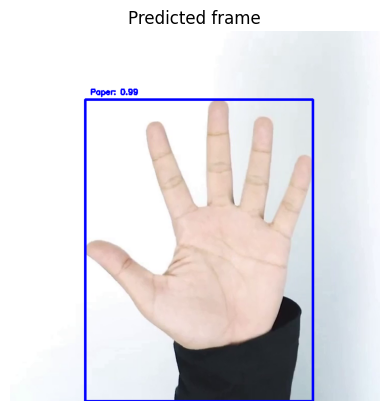

In [98]:
model = load_model('/content/drive/My Drive/test/gesture_classification_model.h5')

class_names = {0: 'Rock', 1: 'Paper', 2: 'Scissors'}

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.7)

video_path = '9.mp4'
cap = cv2.VideoCapture(video_path)

num_frames_to_process = 5
frame_count = 0
background = None

images_to_show = []

while cap.isOpened() and frame_count < num_frames_to_process:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Инициализация фона на первом кадре
    if background is None:
        background = gray
        frame_count += 1
        continue

    # Абсолютная разность между текущим кадром и фоном
    diff = cv2.absdiff(background, gray)

    # Пороговая обработка для получения бинарного изображения
    _, binFrame = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Поиск контуров в бинарном изображении
    contours, hierarchy = cv2.findContours(binFrame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if frame_count == 4:
        images_to_show.append(('Original frame', frame))
        images_to_show.append(('Difference frame', diff))
        images_to_show.append(('Binary frame', binFrame))

        # Черный фон для контура
        contour_image = np.zeros_like(frame)

        if contours:
            # Контуры
            cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)

            # Bounding box
            all_points = np.vstack(contours)
            x, y, w, h = cv2.boundingRect(all_points)
            cv2.rectangle(contour_image, (x, y), (x + w, y + h), (255, 0, 0), 3)

            images_to_show.append(('Contours', contour_image))

            # Обрезка по bounding box
            img_input = frame[y:y+h, x:x+w]

            # Ключевые точки руки
            image_rgb = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
            results = hands.process(image_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    keypoints = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
                    keypoints_normalized = np.array(keypoints) / 1.0
                    img_input_model = np.expand_dims(keypoints_normalized, axis=0) # Добавление размерности для батча

                    predictions = model.predict(img_input_model)             # Предсказание класса жеста
                    predicted_class = np.argmax(predictions[0])              # Получение класса с максимальной вероятностью
                    predicted_probability = predictions[0][predicted_class]  # Вероятность предсказанного класса

                    annotated_frame = frame.copy()

                    cv2.rectangle(annotated_frame, (x, y), (x + w, y + h), (255, 0, 0), 3)
                    text = f'{class_names[predicted_class]}: {predicted_probability:.2f}'
                    cv2.putText(annotated_frame, text, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

                    images_to_show.append(('Predicted frame', annotated_frame))

        else:
            print("Рука не обнаружена.")

    frame_count += 1

cap.release()
cv2.destroyAllWindows()

for title, img in images_to_show:
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

### Test

In [36]:
model = load_model('/content/drive/My Drive/test/gesture_classification_model.h5')

class_names = {0: 'Rock', 1: 'Paper', 2: 'Scissors'}

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.7)

video_path = 'test_1.mp4'
cap = cv2.VideoCapture(video_path)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

output_path = 'result_1.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0
background = None

color =(0, 0, 255)

while cap.isOpened():
    ret, frame = cap.read()  # Читаем кадр из видео
    if not ret:
        break

    # Преобразуем изображение в оттенки серого
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Инициализация фона при первом кадре
    if background is None:
        background = gray
        frame_count += 1
        continue

    # Абсолютная разность между текущим кадром и фоном
    diff = cv2.absdiff(background, gray)

    # Пороговая обработка для получения бинарного изображения
    _, binFrame = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Контуры в бинарном изображении
    contours, hierarchy = cv2.findContours(binFrame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    frameCopy = frame.copy()

    if contours:
        # Bounding box
        all_points = np.vstack(contours)
        x, y, w, h = cv2.boundingRect(all_points)

        # Увеличиваем рамку
        padding = 30
        x -= padding
        y -= padding
        w += padding * 2
        h += padding * 2

        # Проверяем границы изображения
        x = max(0, x)
        y = max(0, y)
        w = min(frame.shape[1] - x, w)
        h = min(frame.shape[0] - y, h)

        # Bounding box
        cv2.rectangle(frameCopy, (x, y), (x + w, y + h), color, 3)

        # Обрезаем по bounding box
        img_input = frame[y:y+h, x:x+w]

        # Изменение яркости и контрастности
        # brightness = 10
        # contrast = 10
        # img_input_adjusted = cv2.convertScaleAbs(img_input, alpha=(contrast / 127 + 1), beta=brightness)
        # frameCopy[y:y+h, x:x+w] = img_input_adjusted

        # Ключевые точки рук
        image_rgb = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                keypoints = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
                keypoints_normalized = np.array(keypoints) / 1.0
                img_input_model = np.expand_dims(keypoints_normalized, axis=0)  # Добавляем размерность для батча

                predictions = model.predict(img_input_model)
                predicted_class = np.argmax(predictions[0])
                predicted_probability = predictions[0][predicted_class]

                text = f'{class_names[predicted_class]}: {predicted_probability:.2f}'
                cv2.putText(frameCopy, text, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    else:
        print("Рука не обнаружена.")

    out.write(frameCopy)

    frame_count += 1

cap.release()
out.release()
cv2.destroyAllWindows()

Рука не обнаружена.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17

In [37]:
model = load_model('/content/drive/My Drive/test/gesture_classification_model.h5')

class_names = {-1: 'None', 0: 'Rock', 1: 'Paper', 2: 'Scissors'}

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.7)

video_path = 'test_1.mp4'
cap = cv2.VideoCapture(video_path)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

output_path = 'fin_result_1.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0
background = None
predicted_class = -1
predicted_probability = 0.0

while cap.isOpened():
    ret, frame = cap.read()  # Читаем кадр из видео
    if not ret:
        break

    # Преобразуем изображение в оттенки серого
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Инициализация фона при первом кадре
    if background is None:
        background = gray
        frame_count += 1
        continue

    # Абсолютная разность между текущим кадром и фоном
    diff = cv2.absdiff(background, gray)

    # Пороговая обработка для получения бинарного изображения
    _, binFrame = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Контуры в бинарном изображении
    contours, hierarchy = cv2.findContours(binFrame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    frameCopy = frame.copy()

    if contours:
        # Bounding box
        all_points = np.vstack(contours)
        x, y, w, h = cv2.boundingRect(all_points)

        # Увеличиваем рамку
        padding = 10
        x -= padding
        y -= padding
        w += padding * 2
        h += padding * 2

        # Проверяем границы изображения
        x = max(0, x)
        y = max(0, y)
        w = min(frame.shape[1] - x, w)
        h = min(frame.shape[0] - y, h)

        # Bounding box
        cv2.rectangle(frameCopy, (x, y), (x + w, y + h), (255, 0, 0), 3)

        # Обрезаем по bounding box
        img_input = frame[y:y+h, x:x+w]

        # Изменение яркости и контрастности
        # brightness = 10
        # contrast = 10
        # img_input_adjusted = cv2.convertScaleAbs(img_input, alpha=(contrast / 127 + 1), beta=brightness)
        # frameCopy[y:y+h, x:x+w] = img_input_adjusted

        if (frame_count + 1) % fps == 0:
            # Ключевые точки рук
            image_rgb = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
            results = hands.process(image_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    keypoints = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
                    keypoints_normalized = np.array(keypoints) / 1.0
                    img_input_model = np.expand_dims(keypoints_normalized, axis=0)  # Добавляем размерность для батча

                    predictions = model.predict(img_input_model)
                    predicted_class = np.argmax(predictions[0])
                    predicted_probability = predictions[0][predicted_class]

            # Красный
            color = (0, 0, 255)

        else:

            # Синий
            color = (255, 0, 0)

        cv2.rectangle(frameCopy, (x, y), (x + w, y + h), color, 3)
        if predicted_class is not None:
            text = f'{class_names[predicted_class]}: {predicted_probability:.2f}'
            cv2.putText(frameCopy, text, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    else:
        print("Рука не обнаружена.")

    out.write(frameCopy)

    frame_count += 1

cap.release()
out.release()
cv2.destroyAllWindows()

Рука не обнаружена.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
